<img src="images/OFE-color-horizontal.png" width="300"> 

# Relative Binding Free Energies in the TYK2 System with ``openfe``

This tutorial demonstrates how to set up and run a network of **Relative Binding Free Energy (RBFE)** calculations using the OpenFE toolkit.

Specifically we cover:
* Loading and defining systems
* Atom mapping and network creation
* Creating & running RBFE simulations
* Analyzing free energy results
* Using the Python & CLI interfaces

<img src="images/rbfe_thermocycle.png" width="450"/>

## Test case: MCL-1 Fragments

* A set of **14 fragment** elaborations from a screen by *Friberg et al., J. Med Chem. 2013*.

* Part of the FEP+ fragment study by *Steinbrecher et al. J. Chem. Inf. Model 2015*

<img src="images/mcl1_frag_elaboration.png" width="350"/><img src="images/mcl1_site.png" width="300"/>

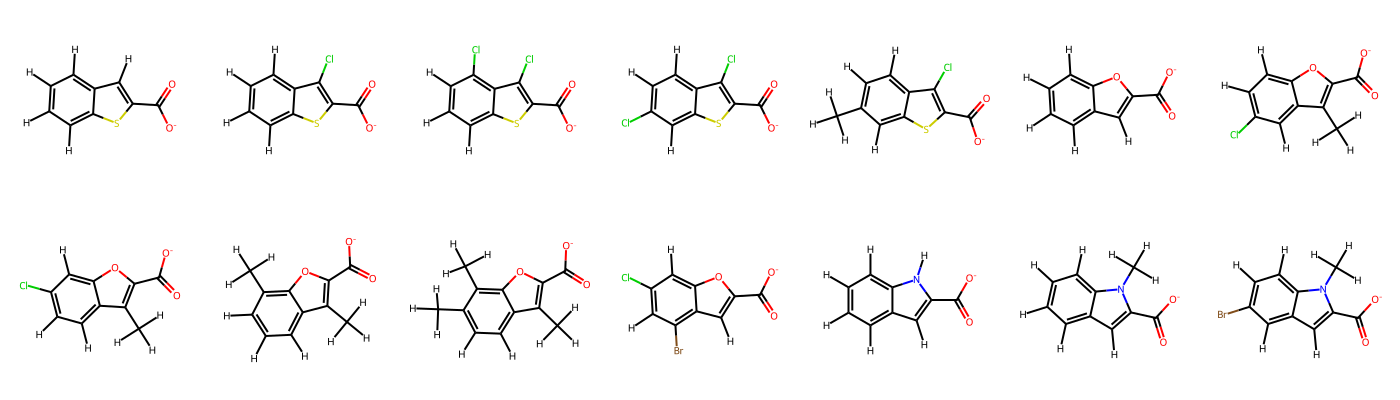

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

# Extract SDF contents, generate 2D coords (note: non-aligned scaffold!)
ligand_rdmols = [m for m in Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)]
[AllChem.Compute2DCoords(ligand) for ligand in ligand_rdmols]

Chem.Draw.MolsToGridImage(ligand_rdmols, molsPerRow=7)

## Workflow Overview

| **Step** | **External Tooling Used** |
|:---------|:----------------|
| 1. Creating OpenFE Components | RDKit, OpenMM, OpenFF |
| 2. Generating Atom Mappings | Kartograf, RDKit |
| 3. Creating a Ligand Network | Lomap, Networkx |
| 4. Defining a network of RBFE Alchemical Transformations | |
| 5. Running the simulations | OpenMM, OpenMMTools, Perses, OpenFF |
| 6. Gathering results | OpenMMTools, PyMBAR |
| 7. Analysis | Cinnabar, Matplotlib |

<img src="images/RBFE_overview.png"/>

## OpenFE Components

<img src="images/OpenFEComponents.png"/>

In [27]:
import openfe
from openff.units import unit

# ProteinComponent
protein = openfe.ProteinComponent.from_pdb_file('inputs/protein.pdb')

# SolventComponent
solvent = openfe.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True,
    ion_concentration=0.15*unit.nanomolar
)

# Ligands
ligand_mols = [
    openfe.SmallMoleculeComponent(sdf)
    for sdf in Chem.SDMolSupplier(
        'inputs/ligands.sdf', removeHs=False
    )
]

## Mapping Ligands

An atom mapping defines the atoms being mutated (and how) during the alchemical transformation.

* Uncoloured atoms: "mapped same elements"
* Blue atoms: "mapped different elements"
* Red atoms: "endstate dummy atoms"

In OpenFE we currently have two atom mappers:
1. `LomapAtomMapper` (MCS-based)

2. `KartografAtomMapper` (Geometry-based)

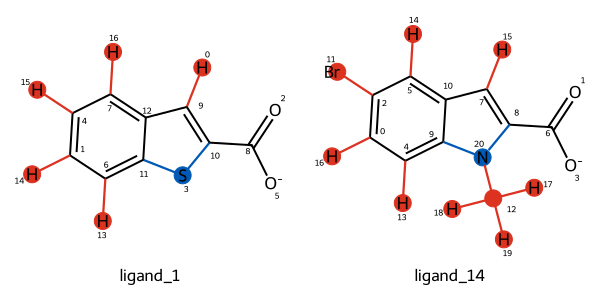

In [28]:
from kartograf import KartografAtomMapper

mapper = KartografAtomMapper(atom_map_hydrogens=False)

atom_mapping = next(
    mapper.suggest_mappings(
        ligand_mols[0], ligand_mols[-1]
    )
)

atom_mapping

<h2><center>Mapping Ligands</center></h2>

We can also visualize the mappings in 3D!

*Note: atoms that have the same sphere color in both end states are mapped (i.e. will be transformed into dummy atoms in the opposite end state), whilst those without spheres are unmaped!*

In [35]:
from openfe.utils import visualization_3D

atom_mapping.view_3d(show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Ligand Transformation Networks

We can use a mapper and a mapping scorer (e.g. `default_lomap_score`) to plan transformation networks between ligands of interest.

OpenFE can create various networks, including:
* Minimum Spanning Tree networks (MST)
* LOMAP networks
* Radial networks
* Loading external networks (e.g. FEP+)
* And many more using Konnektor!

In [39]:
from openfe.setup.ligand_network_planning import (
    generate_lomap_network,
    generate_minimal_spanning_network,
    generate_radial_network,
)
from openfe import lomap_scorers
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Creating a Lomap network
lomap_network = generate_lomap_network(
    ligands=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=[KartografAtomMapper()]
)

# Creating an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=[KartografAtomMapper()]
)

atom mapping:  {0: 0, 13: 12, 14: 13, 15: 14, 16: 15, 1: 1, 2: 2, 3: 16, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}


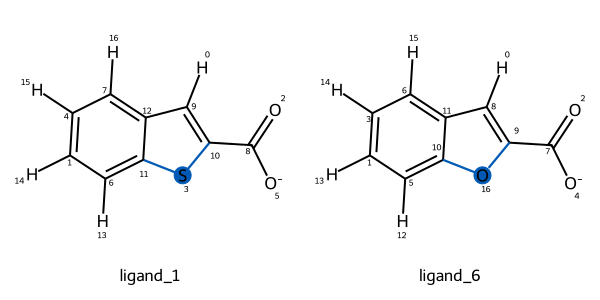

In [40]:
# A network is a collecting of mappings

mst_edges = [edge for edge in mst_network.edges]

print("atom mapping: ", mst_edges[0].componentA_to_componentB)

mst_edges[0]

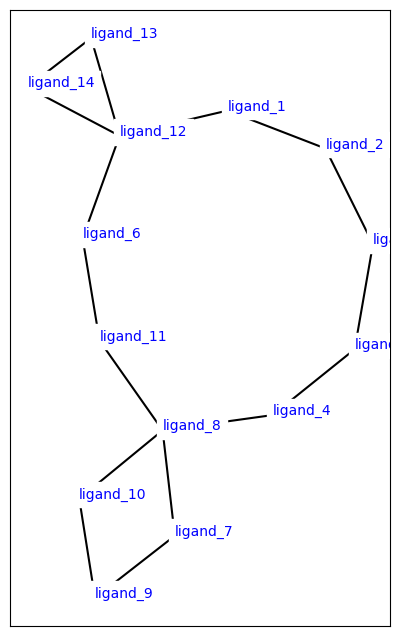

In [44]:
# We can visualize the networks too!
# Note: small visual artifact bug to be fixed ;)

from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(lomap_network,)

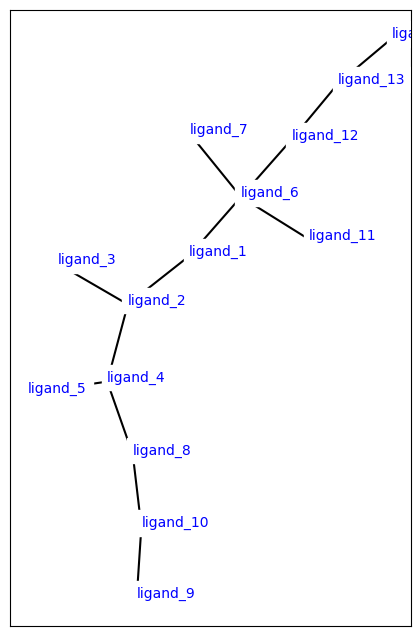

In [42]:
plot_atommapping_network(mst_network)

## Creating an RBFE cycle

For each edge in our ligand network we can define a set of simulations to allow us to recover the **binding free energy**.

To do this we need to define:
  - 2 solvent states
  - 2 complex states
  - A state transformation simulation protocol

![rbfe_cycle](images/rbfe_thermocycle.png)
<img src="images/mcl1_frag_elaboration.png" width="350"/>

<h2><center>Defining end states</center></h2>

* `ChemicalSystems` can be defined for each end state of the cycle.

* These define the `Components` making up each state.

* Free energy Protocols take multiple ChemicalSystems to define the transformation being simulated.

![rbfe_cycle](images/rbfe_thermocycle.png)

<h2><center>Defining end states</center></h2>

In [ ]:
# Selecting a specific edge
edge = mst_edges[0]

# Components are collated into ChemicalSystems
ligand_A_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'protein': protein,
     'solvent': solvent}
)

ligand_A_solvent = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'solvent': solvent}
)

ligand_B_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentB,
     'protein': protein,
     'solvent': solvent}
)

ligand_B_solvent = openfe.ChemicalSystem(
    {'ligand': edge.componentB,
     'solvent': solvent}
)

In [ ]:
# We can inspect the equality of these
# ChemicalSystems to identify differences

another_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'protein': protein,
     'solvent': solvent}
)

print(ligand_A_complex == another_complex)

print(ligand_A_complex == ligand_B_complex)


<h2><center>Creating a simulation Protocol</center></h2>

An OpenFE **Protocol** defines how a simulation will take place.

Here we use the `RelativeHybridTopologyProtocol`, based on Perses, which:
  * Uses a hybrid topology approach
  * Allows for equilibrium samplers; HREX, SAMS, and independent windows
  * Uses OpenMM as a simulation engine

In [ ]:
from openfe.protocols.openmm_rfe import (
    RelativeHybridTopologyProtocol
)

# Protocols require settings, each has a default set
settings = RelativeHybridTopologyProtocol.default_settings()

# We can get the FF version
print(settings.forcefield_settings.small_molecule_forcefield)

# We can set the FF version
settings.forcefield_settings.small_molecule_forcefield = 'openff-2.2'
print(settings.forcefield_settings.small_molecule_forcefield)

<h2><center>Creating a simulation Protocol</center></h2>

* **Protocol** objects are created from their settings and are immutable.

* **Protocol** objects define how to apply a Transformation to a set of input ChemicalSystems & atom mappings.

* **Protocol** objects can be re-used to define multiple simulations.

In [ ]:
# Creating a Protocol for our RBFE simulations

rbfe_protocol = RelativeHybridTopologyProtocol(
    settings=settings
)

<h2><center>Creating Transformations</center></h2>

With `ChemicalSystem`s and a `Protocol` defined, we can create a set of `Transformation`s for our RBFE cycle.

A `Transformation` contains everything necessary to run a single simulation. For our chosen RFE Protocol this requires:
  * Two `ChemicalSystem` defining the end states
  * An atom mapping between the transforming ligands
  * A `Protocol` object
  * A name (optional)

In [ ]:
transformation_complex = openfe.Transformation(
    stateA=ligand_A_complex,
    stateB=ligand_B_complex,
    mapping=edge,
    protocol=rbfe_protocol,
    name="A_to_B_transformation_complex"
)

transformation_solvent = openfe.Transformation(
    stateA=ligand_A_solvent,
    stateB=ligand_B_solvent,
    mapping=edge,
    protocol=rbfe_protocol,
    name="A_to_B_transformation_solvent"
)

<h2><center>Saving Transformations</center></h2>

`Transformation`s can then be saved to file (JSON) for execution at a later date.

Executing a `Transformation` (see later) will yield a free energy estimate for that leg of the thermodynamic cycle.

In [ ]:
import pathlib

out_dir = pathlib.Path("single_transform")
out_dir.mkdir(exist_ok=True)

transformation_complex.dump(
    out_dir / f"{transformation_complex.name}.json"
)

transformation_solvent.dump(
    out_dir / f"{transformation_solvent.name}.json"
)

<h2><center>Networks of Transformations (AlchemicalNetworks)</center></h2>

We can create `AlchemicalNetwork`s which contain all the `Transformation` for all the simulations necessary for a network of RBFE calculations.

In [ ]:
transformations = []
for mapping in mst_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        
        sysA = openfe.ChemicalSystem(sysA_dict)
        sysB = openfe.ChemicalSystem(sysB_dict)
        
        name = (f"{leg}_{mapping.componentA.name}_"
                f"{mapping.componentA.name}")
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=rbfe_protocol,
            name=name
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

In [ ]:
# Similarly we can write out all the AlchemicalNetwork
# Transformations to disk

# first we create the directory
transformation_dir = pathlib.Path("networktransforms")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

In [ ]:
!ls networktransforms